<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/CodeExamples/autoencode_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import glob
import pylab as pl
from PIL import Image

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. change kernel to GPU 
go to runtime -> change runtime type -> GPU

# 2. load faces

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My\ Drive


/content/gdrive/My Drive


In [5]:
cd MLTSA2020

/content/gdrive/My Drive/MLTSA2020


In [6]:

!wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip

--2020-04-30 18:49:32--  https://cswww.essex.ac.uk/mv/allfaces/faces95.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... ^C


In [0]:
!unzip faces95.zip

In [0]:
!ls faces95/*/*jpg

In [59]:
flist = glob.glob("faces95/*/*jpg")
N = len(flist)
N


1440

In [62]:
imgs = np.zeros((N, 35,35, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  imgs[i] = numpy.array(im)[25:165:4,25:165:4,:1].astype(float) / 255 

0


KeyboardInterrupt: ignored

# digits first

11493376/11490434 [==============================] - 2s 0us/step


(60000, 28, 28)

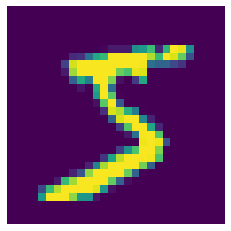

In [7]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

img_rows, img_cols = 28, 28
pl.imshow(x_train[0])
pl.axis('off')
intialshape = x_train[0].shape
ndim = np.prod(x_train[0].shape)
x_train.shape

In [8]:
x_train.dtype, x_train.max(), x_train.min()


(dtype('uint8'), 255, 0)

In [9]:
x_train = (x_train.astype(float) / 255).reshape(len(x_train), ndim)
x_test = (x_test.astype(float) / 255).reshape(len(x_test), ndim)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

# create a model

In [0]:
keras.models?

In [0]:
model_digits64 = Sequential()
## encoder
# input layer and the output size
model_digits64.add(Dense(128, activation='relu', input_dim=ndim))
#compression layer
model_digits64.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64.add(Dense(128, activation='relu'))
#output layer, same size as input
model_digits64.add(Dense(ndim, activation='linear'))


#alternative syntax
"""
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
"""

### regression
- loss='mean_squared_error' L2: default loss to use for regression problems. => linear activation function in output layer, one node out

alternatives:  loss='mean_squared_logarithmic_error', 'mean_absolute_error' (which is L1 instead of L2)
### binary classification

- loss='binary_crossentropy' => sigmoid activation function in output layer, one node out

alternatives: 'hinge'

### multiclass classification
categorical encoded as numerical
- loss='categorical_crossentropy' => softmax n nodes out

onehot encoded categoridal
- 'parse_categorical_crossentropy' => softmax n nodes out

- 'kullback Leibler Divergence Loss' => probabilistic categorical classification; log(P/Q)

## optimizers
- SGD: stocastic gradient descent 
    - nesterov=True -> momentum inclusion
- adam: Adaptive moment estimation. **good in most cases**
- adagrad: different steps for different parameters based on frequency (binary input) well-suited for dealing with sparse data.

- adaDelta: like adagrad but compensated for vanishing learning rate problem

momentum refers to looking one step back and make a decision that includes the slope there

### parameter:
generally you need to adjust the learning rate which is how much you change the parameters by at each step. 
keras.optimizers.Adam(lr=0.001)


https://gitcdn.xyz/cdn/Tony607/blog_statics/e1a0b1e060e783bd1978a141acff897ae71bd021/images/optimizer/optimizer.gif

In [0]:
# choose the optimizer and loss appropriately!
model_digits64.compile(optimizer="adadelta", loss="mean_squared_error")

In [0]:
print(model_digits64.summary())

In [0]:
history64 = model_digits64.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20, batch_size=100, verbose=1)

# always look at the loss!

In [0]:
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

# predict

In [0]:
output_image64 = model_digits64.predict(x_test)

In [0]:
def compareinout(i, outim, testimg, initialshape=(28,28)):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(121) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(122) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


In [0]:
for i in range(10):
  compareinout(i, output_image64, x_test)

# change loss function

In [0]:
# choose the optimizer and loss appropriately!
model_digits64_sig = Sequential()
## encoder
# input layer and the output size
model_digits64_sig.add(Dense(128, activation='relu', input_dim=ndim))
#compression layer
model_digits64_sig.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64_sig.add(Dense(128, activation='relu'))
#output layer, same size as input
model_digits64_sig.add(Dense(ndim, activation='sigmoid'))
model_digits64_sig.compile(optimizer="adadelta", loss="mean_squared_error") #binary_cross_entropy)

In [0]:
history64_sig = model_digits64_sig.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=20, batch_size=100, verbose=1)

In [0]:
pl.plot(np.array(history64_sig.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

In [0]:
output_image64_sig = model_digits64_sig.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_sig, x_test)

In [0]:
# sigmoid and binary cross entropy loss
model_digits64_bce = model_digits64_sig

In [0]:
model_digits64_bce.compile(optimizer="adadelta", loss="binary_crossentropy")
history64_bce = model_digits64_bce.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=20, batch_size=100, verbose=1)

In [0]:
pl.plot(np.array(history64_bce.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

In [0]:
output_image64_bce = model_digits64_bce.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_bce, x_test)

In [0]:
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend()
pl.figure()
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.xscale('log')
pl.yscale('log')
pl.legend()

# try more compression

In [0]:
model_digits = Sequential()
#encoder
model_digits.add(Dense(128, activation='relu', input_dim=ndim))
model_digits.add(Dense(64, activation='relu'))
model_digits.add(Dense(32, activation='relu'))
#bottle neck
model_digits.add(Dense(16, activation='relu'))
#decoder
model_digits.add(Dense(32, activation='relu'))
model_digits.add(Dense(64, activation='relu'))
model_digits.add(Dense(128, activation='relu'))
model_digits.add(Dense(ndim, activation='sigmoid'))


In [0]:
model_digits.compile(optimizer="adadelta", loss="binary_crossentropy")

In [12]:
print(model_digits.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [13]:
history = model_digits.fit(x_train, x_train, epochs=20, batch_size=100, verbose=1)

Epoch 1/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.2945
Epoch 2/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.2500
Epoch 3/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.2351
Epoch 4/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.2176
Epoch 5/20
60000/60000 [==============================] - 3s 54us/step - loss: 0.2014
Epoch 6/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.1837
Epoch 7/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.1741
Epoch 8/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.1658
Epoch 9/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.1604
Epoch 10/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1563
Epoch 11/20
60000/60000 [==============================] - 3s 53us/step - loss: 0.1531
Epoch 12/20
60000/60000 [===========================

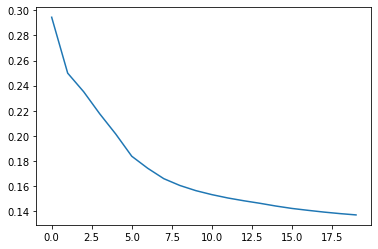

In [14]:
pl.plot(np.array(history.history['loss']))
pl.yscale('log')
pl.xscale('log')

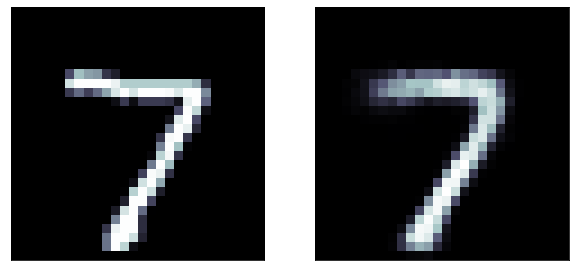

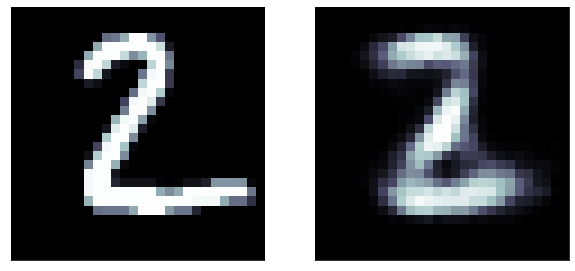

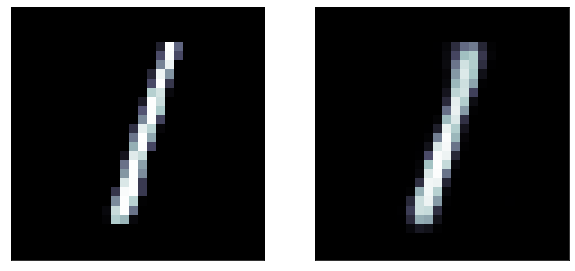

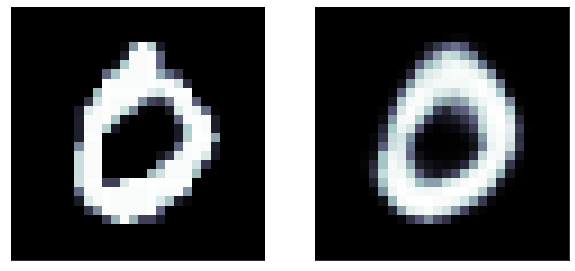

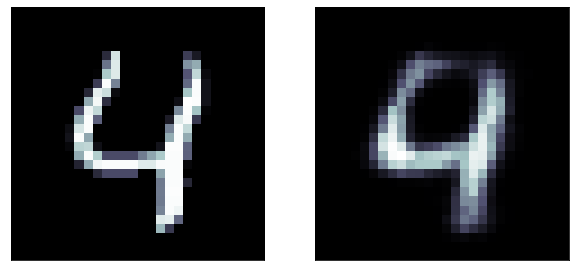

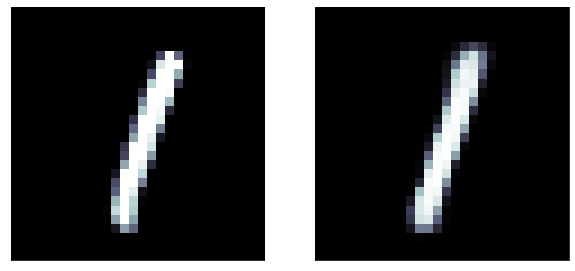

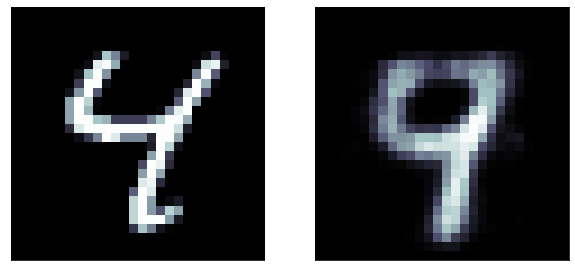

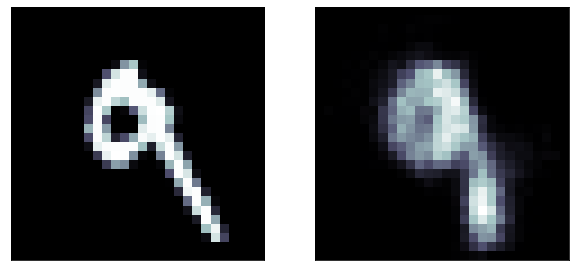

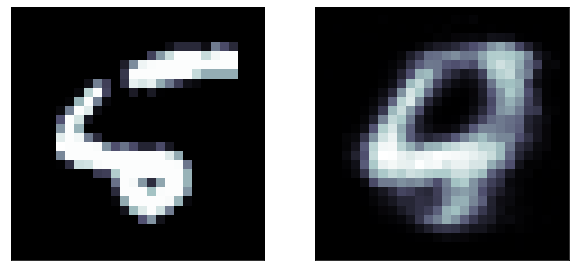

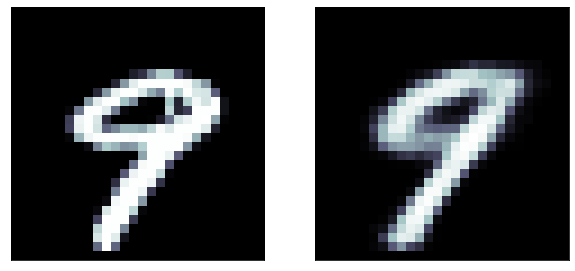

In [17]:
output_image = model_digits.predict(x_test)

for i in range(10):
  compareinout(i, output_image, x_test)

# Extract feature

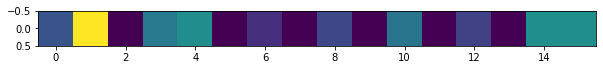

In [42]:
from keras import backend as K

inp = model_digits.input                                           # input placeholder
outputs = model_digits.layers[3].output         # all layer outputs
functors = K.function([inp], [outputs])    # evaluation functions

# Testing
layer_outs = functors(x_test[:1])
pl.imshow(layer_outs[0])

In [0]:
def compareinout_encoded(i, outim, testimg, initialshape=(28,28)):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  pl.imshow(functors(testimg[i:i+1])[0])
  ax = fig.add_subplot(133) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


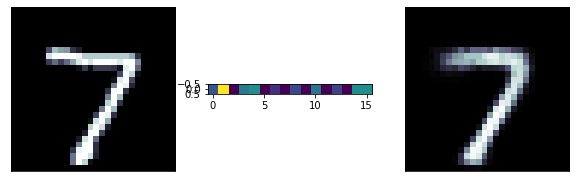

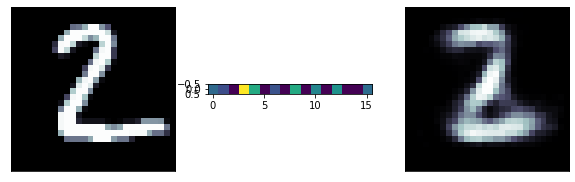

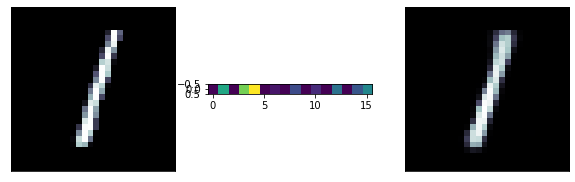

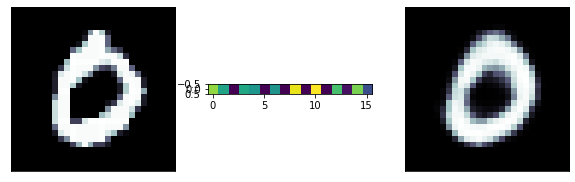

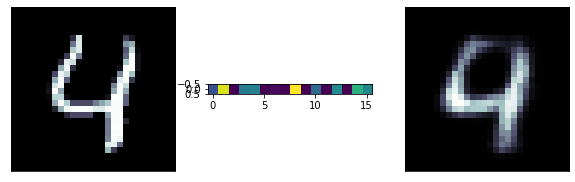

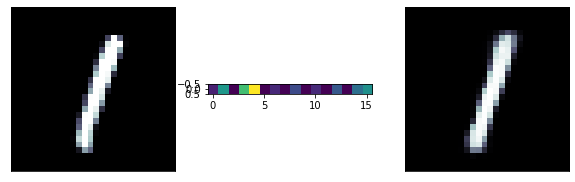

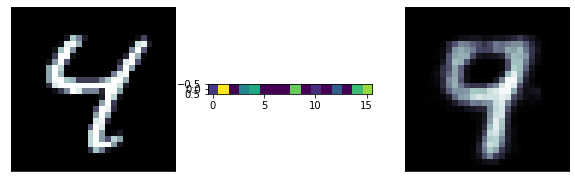

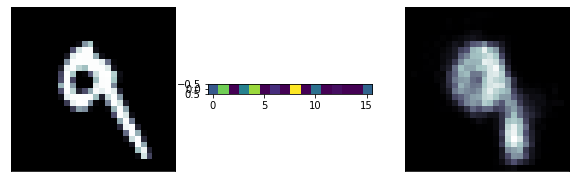

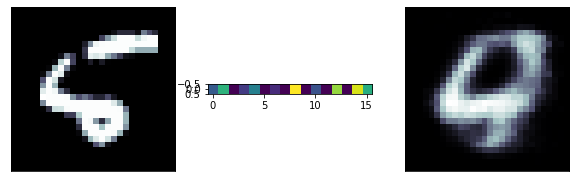

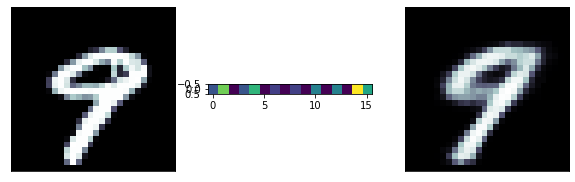

In [55]:
for i in range(10):
  compareinout_encoded(i, output_image, x_test)